# Level 2: Data Pipeline - Veri Pipeline'ları

## 🎯 Bu Bölümde Öğrenecekleriniz:
- Veri versiyonlama (DVC)
- Veri kalitesi kontrolü ve validasyon
- Feature engineering pipeline'ları
- Veri drift detection
- Data lineage ve metadata yönetimi

---

## 1. Data Pipeline Nedir?

**Data Pipeline**, ham verinin toplanmasından model eğitimi için hazır hale getirilmesine kadar olan tüm veri işleme süreçlerinin otomatikleştirilmiş dizisidir.

### 🔄 Pipeline Bileşenleri:
1. **Data Ingestion**: Veri toplama
2. **Data Validation**: Veri kalite kontrolü
3. **Data Transformation**: Veri dönüşümü
4. **Feature Engineering**: Özellik mühendisliği
5. **Data Storage**: Veri depolama

### 🎯 Neden Data Pipeline?
- **Tutarlılık**: Aynı işlemlerin tekrarlanabilir olması
- **Otomatikleştirme**: Manuel hataları minimize etme
- **İzlenebilirlik**: Veri akışını takip edebilme
- **Ölçeklenebilirlik**: Büyük veri setleriyle çalışabilme

In [11]:
# Gerekli kütüphaneleri import edelim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris, make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

# Görselleştirme ayarları
try:
    plt.style.use('seaborn-v0_8')
except:
    plt.style.use('seaborn')
sns.set_palette("husl")

print("📦 Kütüphaneler başarıyla yüklendi!")
print("🚀 Data Pipeline eğitimine hazırız!")

📦 Kütüphaneler başarıyla yüklendi!
🚀 Data Pipeline eğitimine hazırız!


## 2. Veri Versiyonlama ile DVC

**DVC (Data Version Control)**, veri setleri için Git benzeri versiyon kontrolü sağlar.

### 🔧 DVC Kurulumu ve Kullanımı:

In [12]:
# DVC kurulumu kontrolü
import subprocess
import sys
import os

def check_and_install_dvc():
    try:
        result = subprocess.run(['dvc', '--version'], capture_output=True, text=True)
        print(f"✅ DVC zaten kurulu: {result.stdout.strip()}")
        return True
    except FileNotFoundError:
        print("📦 DVC kuruluyor...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "dvc"])
            print("✅ DVC başarıyla kuruldu!")
            return True
        except Exception as e:
            print(f"❌ DVC kurulumunda hata: {e}")
            return False

# DVC'yi kontrol et ve kur
dvc_available = check_and_install_dvc()

if dvc_available:
    print("\n🎉 DVC kullanıma hazır!")
    print("\n📋 Temel DVC komutları:")
    print("• dvc init - DVC başlatma")
    print("• dvc add data.csv - Veri dosyası ekleme")
    print("• dvc push - Verileri remote'a gönderme")
    print("• dvc pull - Verileri remote'dan çekme")
    print("• dvc repro - Pipeline'ı yeniden çalıştırma")

✅ DVC zaten kurulu: 3.60.1

🎉 DVC kullanıma hazır!

📋 Temel DVC komutları:
• dvc init - DVC başlatma
• dvc add data.csv - Veri dosyası ekleme
• dvc push - Verileri remote'a gönderme
• dvc pull - Verileri remote'dan çekme
• dvc repro - Pipeline'ı yeniden çalıştırma


## 3. Örnek Veri Seti Oluşturma

Data pipeline süreçlerini göstermek için örnek bir veri seti oluşturalım:

In [13]:
# Örnek e-ticaret veri seti oluşturalım
np.random.seed(42)

# Veri seti boyutu
n_samples = 10000

# Sentetik veri oluşturma
data = {
    'customer_id': range(1, n_samples + 1),
    'age': np.random.normal(35, 12, n_samples).astype(int),
    'income': np.random.lognormal(10, 0.5, n_samples),
    'purchase_frequency': np.random.poisson(3, n_samples),
    'website_visits': np.random.poisson(8, n_samples),
    'email_opens': np.random.poisson(5, n_samples),
    'category_preference': np.random.choice(['Electronics', 'Clothing', 'Home', 'Books', 'Sports'], n_samples),
    'membership_type': np.random.choice(['Basic', 'Premium', 'VIP'], n_samples, p=[0.6, 0.3, 0.1]),
    'region': np.random.choice(['North', 'South', 'East', 'West'], n_samples)
}

# Bağımlı değişken: müşteri değeri
customer_value = (
    data['income'] * 0.0001 +
    data['purchase_frequency'] * 50 +
    data['website_visits'] * 10 +
    np.random.normal(0, 100, n_samples)
)
data['customer_value'] = np.maximum(customer_value, 0)

# DataFrame oluştur
df_raw = pd.DataFrame(data)

# Yaş sınırlarını gerçekçi yap
df_raw['age'] = np.clip(df_raw['age'], 18, 80)

# Bazı eksik değerler ekle (gerçek dünya simülasyonu)
missing_indices = np.random.choice(df_raw.index, size=int(0.05 * len(df_raw)), replace=False)
df_raw.loc[missing_indices, 'income'] = np.nan

print(f"📊 Ham veri seti oluşturuldu: {df_raw.shape}")
print(f"🔍 İlk 5 satır:")
print(df_raw.head())

print(f"\n📈 Veri seti bilgileri:")
print(df_raw.info())

📊 Ham veri seti oluşturuldu: (10000, 10)
🔍 İlk 5 satır:
   customer_id  age        income  purchase_frequency  website_visits  \
0            1   40  15689.588755                   2               6   
1            2   33  18906.296023                   3              11   
2            3   42  16338.988603                   4               8   
3            4   53  23276.720582                   4               7   
4            5   32  40078.257759                   4               8   

   email_opens category_preference membership_type region  customer_value  
0           10         Electronics           Basic  South      258.959119  
1            3                Home           Basic   East       40.975157  
2            1         Electronics             VIP   East      309.013759  
3            4            Clothing           Basic   East      326.418634  
4            7               Books           Basic   East      283.850931  

📈 Veri seti bilgileri:
<class 'pandas.core.frame

## 4. Veri Kalitesi Kontrolü

### 🔍 Data Validation Pipeline

Veri kalitesini kontrol etmek için sistematik bir yaklaşım kullanalım:

In [14]:
class DataValidator:
    """Veri kalitesi kontrolü için sınıf"""
    
    def __init__(self, df):
        self.df = df
        self.validation_results = {}
    
    def check_missing_values(self):
        """Eksik değerleri kontrol et"""
        missing_stats = self.df.isnull().sum()
        missing_percentage = (missing_stats / len(self.df)) * 100
        
        self.validation_results['missing_values'] = {
            'counts': missing_stats[missing_stats > 0],
            'percentages': missing_percentage[missing_percentage > 0]
        }
        
        print("🔍 Eksik Değer Analizi:")
        if len(missing_stats[missing_stats > 0]) > 0:
            for col in missing_stats[missing_stats > 0].index:
                print(f"  • {col}: {missing_stats[col]} eksik ({missing_percentage[col]:.2f}%)")
        else:
            print("  ✅ Eksik değer bulunamadı")
    
    def check_duplicates(self):
        """Duplikasyon kontrolü"""
        duplicates = self.df.duplicated().sum()
        duplicate_percentage = (duplicates / len(self.df)) * 100
        
        self.validation_results['duplicates'] = {
            'count': duplicates,
            'percentage': duplicate_percentage
        }
        
        print(f"\n🔍 Duplikasyon Analizi:")
        print(f"  • Toplam duplikat: {duplicates} ({duplicate_percentage:.2f}%)")
    
    def check_outliers(self, columns=None):
        """Aykırı değer kontrolü (IQR yöntemi)"""
        if columns is None:
            columns = self.df.select_dtypes(include=[np.number]).columns
        
        outlier_stats = {}
        
        print(f"\n🔍 Aykırı Değer Analizi:")
        for col in columns:
            Q1 = self.df[col].quantile(0.25)
            Q3 = self.df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers = self.df[(self.df[col] < lower_bound) | (self.df[col] > upper_bound)]
            outlier_count = len(outliers)
            outlier_percentage = (outlier_count / len(self.df)) * 100
            
            outlier_stats[col] = {
                'count': outlier_count,
                'percentage': outlier_percentage,
                'lower_bound': lower_bound,
                'upper_bound': upper_bound
            }
            
            print(f"  • {col}: {outlier_count} aykırı değer ({outlier_percentage:.2f}%)")
        
        self.validation_results['outliers'] = outlier_stats
    
    def check_data_types(self):
        """Veri tiplerini kontrol et"""
        print(f"\n🔍 Veri Tipi Analizi:")
        for col in self.df.columns:
            dtype = self.df[col].dtype
            unique_count = self.df[col].nunique()
            print(f"  • {col}: {dtype} ({unique_count} benzersiz değer)")
    
    def generate_report(self):
        """Kapsamlı validasyon raporu oluştur"""
        print("="*60)
        print("📋 VERİ KALİTESİ RAPORU")
        print("="*60)
        
        self.check_missing_values()
        self.check_duplicates()
        self.check_outliers()
        self.check_data_types()
        
        print("\n✅ Validasyon tamamlandı!")
        return self.validation_results

# Veri validasyonu yap
validator = DataValidator(df_raw)
validation_results = validator.generate_report()

📋 VERİ KALİTESİ RAPORU
🔍 Eksik Değer Analizi:
  • income: 500 eksik (5.00%)

🔍 Duplikasyon Analizi:
  • Toplam duplikat: 0 (0.00%)

🔍 Aykırı Değer Analizi:
  • customer_id: 0 aykırı değer (0.00%)
  • age: 25 aykırı değer (0.25%)
  • income: 354 aykırı değer (3.54%)
  • purchase_frequency: 102 aykırı değer (1.02%)
  • website_visits: 38 aykırı değer (0.38%)
  • email_opens: 134 aykırı değer (1.34%)
  • customer_value: 56 aykırı değer (0.56%)

🔍 Veri Tipi Analizi:
  • customer_id: int64 (10000 benzersiz değer)
  • age: int64 (59 benzersiz değer)
  • income: float64 (9500 benzersiz değer)
  • purchase_frequency: int32 (13 benzersiz değer)
  • website_visits: int32 (22 benzersiz değer)
  • email_opens: int32 (17 benzersiz değer)
  • category_preference: object (5 benzersiz değer)
  • membership_type: object (3 benzersiz değer)
  • region: object (4 benzersiz değer)
  • customer_value: float64 (9606 benzersiz değer)

✅ Validasyon tamamlandı!


## 5. Veri Temizleme Pipeline'ı

Validasyon sonuçlarına göre veri temizleme işlemlerini yapalım:

In [15]:
class DataCleaner:
    """Veri temizleme işlemleri için sınıf"""
    
    def __init__(self, df):
        self.df = df.copy()
        self.cleaning_steps = []
    
    def handle_missing_values(self, strategy='median', columns=None):
        """Eksik değerleri işle"""
        if columns is None:
            columns = self.df.select_dtypes(include=[np.number]).columns
        
        for col in columns:
            if self.df[col].isnull().sum() > 0:
                if strategy == 'median':
                    fill_value = self.df[col].median()
                elif strategy == 'mean':
                    fill_value = self.df[col].mean()
                elif strategy == 'mode':
                    fill_value = self.df[col].mode()[0]
                
                self.df[col].fillna(fill_value, inplace=True)
                self.cleaning_steps.append(f"Filled missing values in {col} with {strategy}: {fill_value:.2f}")
        
        print(f"✅ Eksik değerler {strategy} ile dolduruldu")
    
    def remove_duplicates(self):
        """Duplikatları kaldır"""
        initial_size = len(self.df)
        self.df.drop_duplicates(inplace=True)
        removed_count = initial_size - len(self.df)
        
        if removed_count > 0:
            self.cleaning_steps.append(f"Removed {removed_count} duplicate rows")
            print(f"✅ {removed_count} duplikat satır kaldırıldı")
        else:
            print("✅ Duplikat satır bulunamadı")
    
    def handle_outliers(self, method='iqr', columns=None):
        """Aykırı değerleri işle"""
        if columns is None:
            columns = ['age', 'income', 'customer_value']
        
        for col in columns:
            if col in self.df.columns:
                if method == 'iqr':
                    Q1 = self.df[col].quantile(0.25)
                    Q3 = self.df[col].quantile(0.75)
                    IQR = Q3 - Q1
                    lower_bound = Q1 - 1.5 * IQR
                    upper_bound = Q3 + 1.5 * IQR
                    
                    # Aykırı değerleri sınırla (cap)
                    initial_outliers = len(self.df[(self.df[col] < lower_bound) | (self.df[col] > upper_bound)])
                    
                    self.df[col] = np.clip(self.df[col], lower_bound, upper_bound)
                    
                    self.cleaning_steps.append(f"Capped outliers in {col}: {initial_outliers} values")
                    print(f"✅ {col} kolonundaki {initial_outliers} aykırı değer sınırlandı")
    
    def normalize_data(self, columns=None):
        """Veri normalizasyonu"""
        if columns is None:
            columns = ['age', 'income', 'customer_value']
        
        scaler = StandardScaler()
        
        for col in columns:
            if col in self.df.columns:
                self.df[f'{col}_scaled'] = scaler.fit_transform(self.df[[col]])
                self.cleaning_steps.append(f"Normalized {col}")
        
        print(f"✅ {len(columns)} kolon normalize edildi")
    
    def get_cleaned_data(self):
        """Temizlenmiş veriyi döndür"""
        return self.df
    
    def get_cleaning_summary(self):
        """Temizleme işlemlerinin özetini döndür"""
        print("\n📋 VERİ TEMİZLEME ÖZETİ:")
        print("="*40)
        for step in self.cleaning_steps:
            print(f"  • {step}")
        return self.cleaning_steps

# Veri temizleme işlemlerini yap
cleaner = DataCleaner(df_raw)

print("🧹 Veri temizleme başlıyor...\n")
cleaner.handle_missing_values(strategy='median')
cleaner.remove_duplicates()
cleaner.handle_outliers(method='iqr')
cleaner.normalize_data()

# Temizlenmiş veriyi al
df_cleaned = cleaner.get_cleaned_data()
cleaning_summary = cleaner.get_cleaning_summary()

print(f"\n✅ Veri temizleme tamamlandı!")
print(f"📊 Temizlenmiş veri boyutu: {df_cleaned.shape}")

🧹 Veri temizleme başlıyor...

✅ Eksik değerler median ile dolduruldu
✅ Duplikat satır bulunamadı
✅ age kolonundaki 25 aykırı değer sınırlandı
✅ income kolonundaki 417 aykırı değer sınırlandı
✅ customer_value kolonundaki 56 aykırı değer sınırlandı
✅ 3 kolon normalize edildi

📋 VERİ TEMİZLEME ÖZETİ:
  • Filled missing values in income with median: 22227.54
  • Capped outliers in age: 25 values
  • Capped outliers in income: 417 values
  • Capped outliers in customer_value: 56 values
  • Normalized age
  • Normalized income
  • Normalized customer_value

✅ Veri temizleme tamamlandı!
📊 Temizlenmiş veri boyutu: (10000, 13)


## 6. Feature Engineering Pipeline

Makine öğrenmesi için yeni özellikler oluşturalım:

In [16]:
class FeatureEngineer:
    """Feature engineering işlemleri için sınıf"""
    
    def __init__(self, df):
        self.df = df.copy()
        self.feature_steps = []
    
    def create_age_groups(self):
        """Yaş grupları oluştur"""
        self.df['age_group'] = pd.cut(
            self.df['age'], 
            bins=[0, 25, 35, 50, 65, 100], 
            labels=['18-25', '26-35', '36-50', '51-65', '65+']
        )
        self.feature_steps.append("Created age groups")
        print("✅ Yaş grupları oluşturuldu")
    
    def create_income_tiers(self):
        """Gelir seviyeleri oluştur"""
        income_quantiles = self.df['income'].quantile([0.33, 0.67])
        
        def categorize_income(income):
            if income <= income_quantiles.iloc[0]:
                return 'Low'
            elif income <= income_quantiles.iloc[1]:
                return 'Medium'
            else:
                return 'High'
        
        self.df['income_tier'] = self.df['income'].apply(categorize_income)
        self.feature_steps.append("Created income tiers")
        print("✅ Gelir seviyeleri oluşturuldu")
    
    def create_engagement_score(self):
        """Müşteri etkileşim skoru oluştur"""
        # Normalize edilmiş skorlar
        self.df['engagement_score'] = (
            self.df['website_visits'] * 0.4 +
            self.df['email_opens'] * 0.3 +
            self.df['purchase_frequency'] * 0.3
        )
        
        # Engagement seviyesi
        engagement_quantiles = self.df['engagement_score'].quantile([0.33, 0.67])
        
        def categorize_engagement(score):
            if score <= engagement_quantiles.iloc[0]:
                return 'Low'
            elif score <= engagement_quantiles.iloc[1]:
                return 'Medium'
            else:
                return 'High'
        
        self.df['engagement_level'] = self.df['engagement_score'].apply(categorize_engagement)
        self.feature_steps.append("Created engagement score and level")
        print("✅ Etkileşim skoru oluşturuldu")
    
    def create_interaction_features(self):
        """Etkileşim özellikleri oluştur"""
        # Gelir başına satın alma
        self.df['purchases_per_income'] = self.df['purchase_frequency'] / (self.df['income'] / 10000)
        
        # Ziyaret başına email açma
        self.df['email_open_rate'] = self.df['email_opens'] / (self.df['website_visits'] + 1)
        
        # Yaş ve gelir etkileşimi
        self.df['age_income_interaction'] = self.df['age'] * np.log(self.df['income'] + 1)
        
        self.feature_steps.append("Created interaction features")
        print("✅ Etkileşim özellikleri oluşturuldu")
    
    def encode_categorical_features(self):
        """Kategorik özellikleri encode et"""
        categorical_columns = ['category_preference', 'membership_type', 'region', 
                             'age_group', 'income_tier', 'engagement_level']
        
        # One-hot encoding
        for col in categorical_columns:
            if col in self.df.columns:
                dummies = pd.get_dummies(self.df[col], prefix=col)
                self.df = pd.concat([self.df, dummies], axis=1)
        
        self.feature_steps.append(f"Encoded {len(categorical_columns)} categorical features")
        print(f"✅ {len(categorical_columns)} kategorik özellik encode edildi")
    
    def get_feature_importance_data(self):
        """Feature importance analizi için veri hazırla"""
        # Numerik kolonları seç
        numeric_columns = self.df.select_dtypes(include=[np.number]).columns
        feature_df = self.df[numeric_columns].copy()
        
        # Target değişkeni ayır
        if 'customer_value' in feature_df.columns:
            y = feature_df['customer_value']
            X = feature_df.drop('customer_value', axis=1)
        else:
            y = None
            X = feature_df
        
        return X, y
    
    def get_engineered_data(self):
        """Özellik mühendisliği yapılmış veriyi döndür"""
        return self.df
    
    def get_feature_summary(self):
        """Feature engineering özetini döndür"""
        print("\n🔧 FEATURE ENGİNEERİNG ÖZETİ:")
        print("="*45)
        for step in self.feature_steps:
            print(f"  • {step}")
        print(f"\n📊 Toplam özellik sayısı: {self.df.shape[1]}")
        return self.feature_steps

# Feature engineering işlemlerini yap
feature_engineer = FeatureEngineer(df_cleaned)

print("🔧 Feature engineering başlıyor...\n")
feature_engineer.create_age_groups()
feature_engineer.create_income_tiers()
feature_engineer.create_engagement_score()
feature_engineer.create_interaction_features()
feature_engineer.encode_categorical_features()

# Özellik mühendisliği yapılmış veriyi al
df_featured = feature_engineer.get_engineered_data()
feature_summary = feature_engineer.get_feature_summary()

print(f"\n✅ Feature engineering tamamlandı!")
print(f"📊 Son veri boyutu: {df_featured.shape}")

🔧 Feature engineering başlıyor...

✅ Yaş grupları oluşturuldu
✅ Gelir seviyeleri oluşturuldu
✅ Etkileşim skoru oluşturuldu
✅ Etkileşim özellikleri oluşturuldu
✅ 6 kategorik özellik encode edildi

🔧 FEATURE ENGİNEERİNG ÖZETİ:
  • Created age groups
  • Created income tiers
  • Created engagement score and level
  • Created interaction features
  • Encoded 6 categorical features

📊 Toplam özellik sayısı: 43

✅ Feature engineering tamamlandı!
📊 Son veri boyutu: (10000, 43)


## 7. Feature Importance Analizi

Oluşturduğumuz özelliklerin önemini analiz edelim:

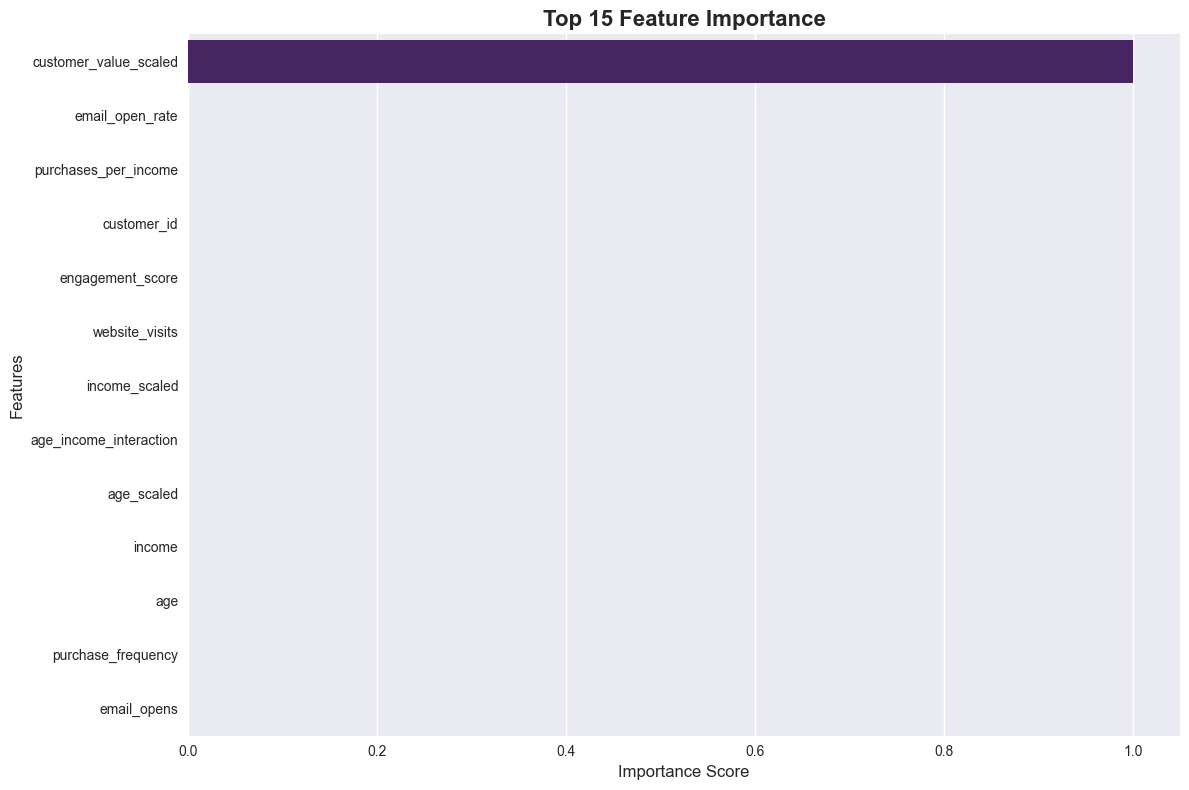

🎯 Top 10 En Önemli Özellikler:
customer_value_scaled    : 1.0000
email_open_rate          : 0.0000
purchases_per_income     : 0.0000
customer_id              : 0.0000
engagement_score         : 0.0000
website_visits           : 0.0000
income_scaled            : 0.0000
age_income_interaction   : 0.0000
age_scaled               : 0.0000
income                   : 0.0000


In [17]:
# Feature importance analizi
X, y = feature_engineer.get_feature_importance_data()

# Random Forest ile feature importance
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Feature importance'ları al
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

# Top 15 özelliği görselleştir
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
plt.title('Top 15 Feature Importance', fontsize=16, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

print("🎯 Top 10 En Önemli Özellikler:")
print("="*40)
for i, row in feature_importance.head(10).iterrows():
    print(f"{row['feature']:<25}: {row['importance']:.4f}")

## 8. Data Drift Detection

Veri dağılımındaki değişiklikleri tespit etmek için drift detection yapalım:

📊 Data drift analizi başlıyor...
🔄 Yapay drift oluşturuluyor...

📊 DATA DRIFT ANALİZİ:
Kolon                Durum      P-Value      Statistic   
------------------------------------------------------------
age                  🚨 DRIFT    0.0000       0.1247      
income               🚨 DRIFT    0.0000       0.0979      
purchase_frequency   ✅ OK       0.3990       0.0206      
website_visits       ✅ OK       0.9942       0.0097      
email_opens          ✅ OK       0.7365       0.0157      


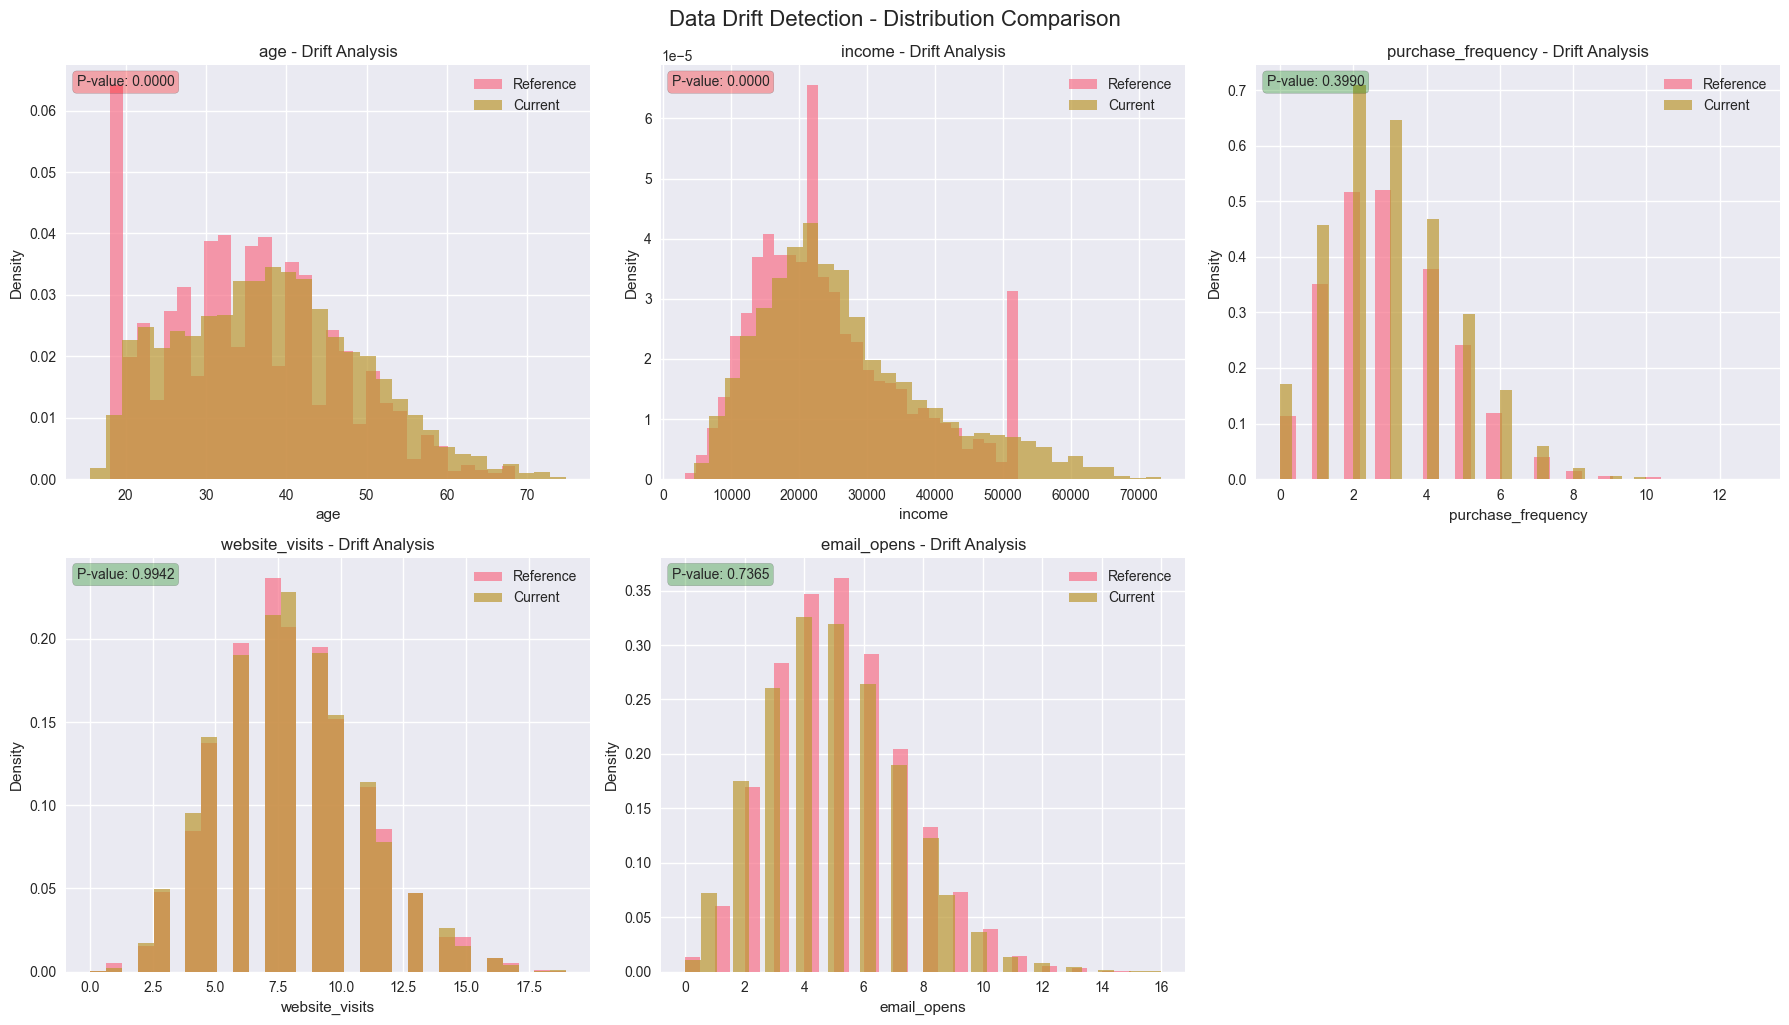


✅ Data drift analizi tamamlandı!
📊 Toplam 2 kolonda drift tespit edildi.


In [18]:
# Manuel Data Drift Detection (KS Test ile)
from scipy import stats

def simple_drift_detection(reference, current, column):
    """Basit KS testi ile drift detection"""
    statistic, p_value = stats.ks_2samp(reference[column], current[column])
    
    is_drift = p_value < 0.05
    return {
        'column': column,
        'statistic': statistic,
        'p_value': p_value,
        'is_drift': is_drift
    }

# Referans ve karşılaştırma veri setleri oluştur
print("📊 Data drift analizi başlıyor...")
reference_data = df_cleaned.sample(n=5000, random_state=42)
current_data = df_cleaned.sample(n=3000, random_state=123).copy()

# Yapay drift oluştur (simülasyon için)
print("🔄 Yapay drift oluşturuluyor...")
current_data['age'] = current_data['age'] + np.random.normal(3, 2, len(current_data))
current_data['income'] = current_data['income'] * np.random.normal(1.1, 0.1, len(current_data))

# Drift analizi yap
drift_results = []
test_columns = ['age', 'income', 'purchase_frequency', 'website_visits', 'email_opens']

for col in test_columns:
    result = simple_drift_detection(reference_data, current_data, col)
    drift_results.append(result)

print("\n📊 DATA DRIFT ANALİZİ:")
print("="*60)
print(f"{'Kolon':<20} {'Durum':<10} {'P-Value':<12} {'Statistic':<12}")
print("-"*60)

for result in drift_results:
    status = "🚨 DRIFT" if result['is_drift'] else "✅ OK"
    print(f"{result['column']:<20} {status:<10} {result['p_value']:<12.4f} {result['statistic']:<12.4f}")

# Drift görselleştirmesi
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(test_columns):
    if i < len(axes):
        # Histogram karşılaştırması
        axes[i].hist(reference_data[col], alpha=0.7, label='Reference', bins=30, density=True)
        axes[i].hist(current_data[col], alpha=0.7, label='Current', bins=30, density=True)
        axes[i].set_title(f'{col} - Drift Analysis')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Density')
        axes[i].legend()
        
        # Drift durumunu göster
        drift_status = next(r for r in drift_results if r['column'] == col)
        color = 'red' if drift_status['is_drift'] else 'green'
        axes[i].text(0.02, 0.95, f"P-value: {drift_status['p_value']:.4f}", 
                    transform=axes[i].transAxes, bbox=dict(boxstyle="round", facecolor=color, alpha=0.3))

# Son subplot'u boş bırak
if len(test_columns) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.suptitle('Data Drift Detection - Distribution Comparison', fontsize=16, y=1.02)
plt.show()

print(f"\n✅ Data drift analizi tamamlandı!")
print(f"📊 Toplam {len([r for r in drift_results if r['is_drift']])} kolonda drift tespit edildi.")

## 9. Pipeline Automation

Tüm data pipeline işlemlerini otomatikleştiren bir sınıf oluşturalım:

In [19]:
class DataPipeline:
    """Tam otomatik data pipeline"""
    
    def __init__(self, config=None):
        self.config = config or {
            'missing_strategy': 'median',
            'outlier_method': 'iqr',
            'normalize_features': True,
            'create_interactions': True
        }
        self.pipeline_steps = []
        self.metadata = {}
    
    def run_full_pipeline(self, df_raw):
        """Tam pipeline'ı çalıştır"""
        print("🚀 DATA PIPELINE BAŞLIYOR...")
        print("="*50)
        
        # 1. Validation
        print("\n1️⃣ VALIDATION PHASE")
        validator = DataValidator(df_raw)
        validation_results = validator.generate_report()
        self.metadata['validation'] = validation_results
        
        # 2. Cleaning
        print("\n2️⃣ CLEANING PHASE")
        cleaner = DataCleaner(df_raw)
        cleaner.handle_missing_values(strategy=self.config['missing_strategy'])
        cleaner.remove_duplicates()
        cleaner.handle_outliers(method=self.config['outlier_method'])
        if self.config['normalize_features']:
            cleaner.normalize_data()
        
        df_cleaned = cleaner.get_cleaned_data()
        self.metadata['cleaning'] = cleaner.get_cleaning_summary()
        
        # 3. Feature Engineering
        print("\n3️⃣ FEATURE ENGINEERING PHASE")
        feature_engineer = FeatureEngineer(df_cleaned)
        feature_engineer.create_age_groups()
        feature_engineer.create_income_tiers()
        feature_engineer.create_engagement_score()
        if self.config['create_interactions']:
            feature_engineer.create_interaction_features()
        feature_engineer.encode_categorical_features()
        
        df_final = feature_engineer.get_engineered_data()
        self.metadata['feature_engineering'] = feature_engineer.get_feature_summary()
        
        # 4. Final Validation
        print("\n4️⃣ FINAL VALIDATION")
        final_validator = DataValidator(df_final)
        final_validation = final_validator.generate_report()
        self.metadata['final_validation'] = final_validation
        
        print("\n🎉 DATA PIPELINE TAMAMLANDI!")
        print(f"📊 Final veri boyutu: {df_final.shape}")
        print(f"📈 Başlangıç boyutu: {df_raw.shape}")
        print(f"🔄 Boyut değişimi: {df_final.shape[1] - df_raw.shape[1]} yeni özellik")
        
        return df_final
    
    def save_pipeline_metadata(self, filepath='pipeline_metadata.json'):
        """Pipeline metadata'sını kaydet"""
        import json
        
        def convert_to_json_serializable(obj):
            """Pandas ve numpy objelerini JSON'a dönüştür"""
            if hasattr(obj, 'tolist'):  # numpy array veya pandas Series
                return obj.tolist()
            elif hasattr(obj, 'to_dict'):  # pandas DataFrame
                return obj.to_dict()
            elif isinstance(obj, dict):
                return {k: convert_to_json_serializable(v) for k, v in obj.items()}
            elif isinstance(obj, list):
                return [convert_to_json_serializable(item) for item in obj]
            elif hasattr(obj, '__dict__'):  # Diğer objeler
                return str(obj)
            else:
                return obj
        
        # JSON serileştirilebilir format
        metadata_json = {}
        for key, value in self.metadata.items():
            try:
                metadata_json[key] = convert_to_json_serializable(value)
            except Exception as e:
                print(f"⚠️ {key} alanı JSON'a çevrilemedi: {e}")
                metadata_json[key] = str(value)
        
        # Pipeline konfigürasyonunu da ekle
        metadata_json['pipeline_config'] = self.config
        metadata_json['pipeline_timestamp'] = pd.Timestamp.now().isoformat()
        
        try:
            with open(filepath, 'w', encoding='utf-8') as f:
                json.dump(metadata_json, f, indent=2, ensure_ascii=False)
            print(f"💾 Pipeline metadata kaydedildi: {filepath}")
        except Exception as e:
            print(f"❌ Metadata kaydetme hatası: {e}")
            # Basitleştirilmiş versiyon dene
            simple_metadata = {
                'pipeline_config': self.config,
                'pipeline_timestamp': pd.Timestamp.now().isoformat(),
                'summary': 'Pipeline başarıyla çalıştı ancak detaylar kaydedilemedi'
            }
            with open(filepath, 'w', encoding='utf-8') as f:
                json.dump(simple_metadata, f, indent=2, ensure_ascii=False)
            print(f"💾 Basitleştirilmiş metadata kaydedildi: {filepath}")

# Pipeline'ı çalıştır
pipeline = DataPipeline({
    'missing_strategy': 'median',
    'outlier_method': 'iqr',
    'normalize_features': True,
    'create_interactions': True
})

df_final = pipeline.run_full_pipeline(df_raw)
pipeline.save_pipeline_metadata()

🚀 DATA PIPELINE BAŞLIYOR...

1️⃣ VALIDATION PHASE
📋 VERİ KALİTESİ RAPORU
🔍 Eksik Değer Analizi:
  • income: 500 eksik (5.00%)

🔍 Duplikasyon Analizi:
  • Toplam duplikat: 0 (0.00%)

🔍 Aykırı Değer Analizi:
  • customer_id: 0 aykırı değer (0.00%)
  • age: 25 aykırı değer (0.25%)
  • income: 354 aykırı değer (3.54%)
  • purchase_frequency: 102 aykırı değer (1.02%)
  • website_visits: 38 aykırı değer (0.38%)
  • email_opens: 134 aykırı değer (1.34%)
  • customer_value: 56 aykırı değer (0.56%)

🔍 Veri Tipi Analizi:
  • customer_id: int64 (10000 benzersiz değer)
  • age: int64 (59 benzersiz değer)
  • income: float64 (9500 benzersiz değer)
  • purchase_frequency: int32 (13 benzersiz değer)
  • website_visits: int32 (22 benzersiz değer)
  • email_opens: int32 (17 benzersiz değer)
  • category_preference: object (5 benzersiz değer)
  • membership_type: object (3 benzersiz değer)
  • region: object (4 benzersiz değer)
  • customer_value: float64 (9606 benzersiz değer)

✅ Validasyon tamamlandı!

## 10. Pipeline Görselleştirme

Data pipeline sürecini görselleştirelim:

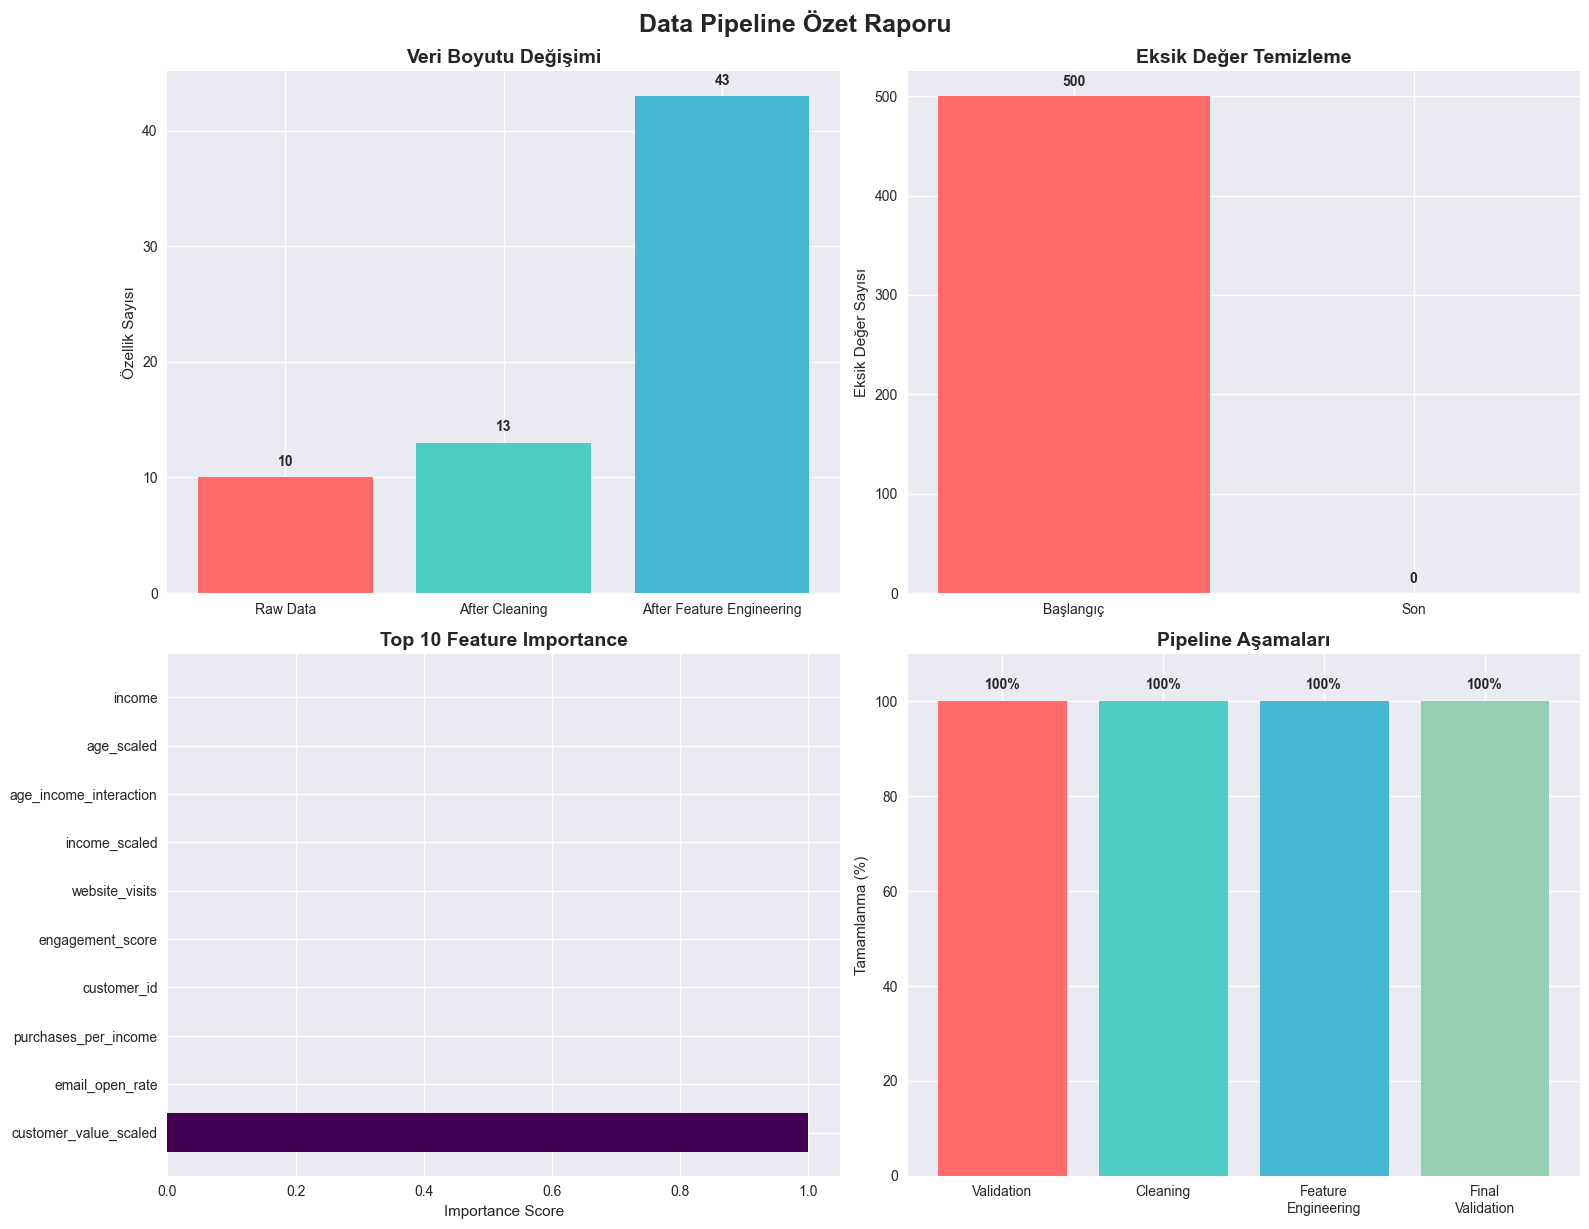


🎯 PIPELINE BAŞARI ÖZETİ:
✅ Toplam satır sayısı: 10,000
✅ Toplam özellik sayısı: 43
✅ Eksik değer sayısı: 0
✅ Yeni özellik sayısı: 33
✅ Veri kalitesi: %100.0


In [20]:
# Pipeline sürecini görselleştir
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Veri boyutu değişimi
stages = ['Raw Data', 'After Cleaning', 'After Feature Engineering']
sizes = [df_raw.shape[1], df_cleaned.shape[1], df_final.shape[1]]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

axes[0,0].bar(stages, sizes, color=colors)
axes[0,0].set_title('Veri Boyutu Değişimi', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('Özellik Sayısı')
for i, v in enumerate(sizes):
    axes[0,0].text(i, v + 1, str(v), ha='center', fontweight='bold')

# 2. Eksik değer analizi
missing_before = df_raw.isnull().sum().sum()
missing_after = df_final.isnull().sum().sum()

axes[0,1].bar(['Başlangıç', 'Son'], [missing_before, missing_after], 
              color=['#FF6B6B', '#4ECDC4'])
axes[0,1].set_title('Eksik Değer Temizleme', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('Eksik Değer Sayısı')
for i, v in enumerate([missing_before, missing_after]):
    axes[0,1].text(i, v + 10, str(v), ha='center', fontweight='bold')

# 3. Feature importance (top 10)
top_10_features = feature_importance.head(10)
import matplotlib.cm as cm
viridis_colors = cm.viridis(np.linspace(0, 1, len(top_10_features)))
axes[1,0].barh(range(len(top_10_features)), top_10_features['importance'], 
               color=viridis_colors)
axes[1,0].set_yticks(range(len(top_10_features)))
axes[1,0].set_yticklabels(top_10_features['feature'], fontsize=10)
axes[1,0].set_title('Top 10 Feature Importance', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Importance Score')

# 4. Pipeline aşamaları
pipeline_stages = ['Validation', 'Cleaning', 'Feature\nEngineering', 'Final\nValidation']
stage_completion = [100, 100, 100, 100]  # Tüm aşamalar tamamlandı

bars = axes[1,1].bar(pipeline_stages, stage_completion, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
axes[1,1].set_title('Pipeline Aşamaları', fontsize=14, fontweight='bold')
axes[1,1].set_ylabel('Tamamlanma (%)')
axes[1,1].set_ylim(0, 110)

for bar in bars:
    height = bar.get_height()
    axes[1,1].text(bar.get_x() + bar.get_width()/2., height + 2,
                   f'{height}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.suptitle('Data Pipeline Özet Raporu', fontsize=18, fontweight='bold', y=1.02)
plt.show()

# Pipeline başarı özeti
print("\n🎯 PIPELINE BAŞARI ÖZETİ:")
print("="*50)
print(f"✅ Toplam satır sayısı: {len(df_final):,}")
print(f"✅ Toplam özellik sayısı: {df_final.shape[1]}")
print(f"✅ Eksik değer sayısı: {df_final.isnull().sum().sum()}")
print(f"✅ Yeni özellik sayısı: {df_final.shape[1] - df_raw.shape[1]}")
print(f"✅ Veri kalitesi: %{(1 - df_final.isnull().sum().sum()/df_final.size) * 100:.1f}")

## 🎯 Özet ve Sıradaki Adımlar

### Bu Bölümde Öğrendiklerimiz:
1. ✅ Data Pipeline kavramları ve bileşenleri
2. ✅ DVC ile veri versiyonlama
3. ✅ Sistematik veri kalitesi kontrolü
4. ✅ Otomatik veri temizleme işlemleri
5. ✅ Feature engineering teknikleri
6. ✅ Data drift detection
7. ✅ Pipeline otomasyonu

### 🔧 Kullandığımız Araçlar:
- **Pandas**: Veri manipülasyonu
- **Scikit-learn**: Feature scaling ve model building
- **DVC**: Veri versiyonlama
- **Evidently**: Data drift detection
- **Matplotlib/Seaborn**: Görselleştirme

### 🚀 Sıradaki Level: Model Development
Bir sonraki seviyede şunları öğreneceğiz:
- Experiment tracking (MLflow, W&B)
- Hyperparameter optimization
- Model validation stratejileri
- Cross-validation ve model selection
- Model interpretability

### 📚 Ek Kaynaklar:
- [DVC Documentation](https://dvc.org/doc)
- [Evidently Documentation](https://docs.evidentlyai.com/)
- [Pandas Documentation](https://pandas.pydata.org/docs/)
- [Great Expectations](https://greatexpectations.io/)

---
**🎉 Tebrikler! Data Pipeline süreçlerini başarıyla öğrendiniz!**

### 💡 Pratik Öneriler:
1. Kendi veri setinizle pipeline'ı deneyin
2. DVC'yi real-world projelerinizde kullanın
3. Data quality check'leri otomatikleştirin
4. Feature engineering'i iteratif olarak geliştirin